# Adding noise to our model: Weighted Least Squares regression

Noise is important in our applications. Sometimes I have measurements of stellar flux from different telescopes, or different times and I know they have different noise properties. Sometimes I have spectra that are noisier at particular wavelengths. It's important to be able to fold that information into our model. Let's start down this path.

Let's make our dataset again, but this time, let's add some noisier data. This might happen because of some measurement error.

[Text(0.5, 0, 'x'), Text(0, 0.5, 'data'), Text(0.5, 1.0, 'Fake Data')]

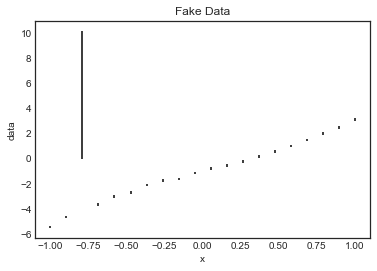

In [73]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

n = 20 # the number of data points
m = 4 # the order of our polynomial
x = np.linspace(-1, 1, n)
A = np.vstack([x**idx for idx in range(m)]).T

# In this step, I'm going to make some fake data for us to fit
true_w = np.random.normal(size=m)
data = A.dot(true_w) + np.random.normal(0, 0.1, size=x.shape[0])
error = np.ones(x.shape[0]) * 0.1

bad_idx = np.random.choice(np.arange(n), 1)
data[bad_idx] += np.random.normal(0, 5, size=1)
error[bad_idx] += 5

fig, ax = plt.subplots()
plt.errorbar(x, data, error, c='k', ls='')
ax.set(xlabel='x', ylabel='data', title='Fake Data')

**Note:** In this scenario, you **know** the noise for each data point. And you **know** the errors on those outlier datapoints. We'll touch on this again soon.

If we use OLS regression, which doesn't take into account these measurement errors, we're now going to get the wrong answer.

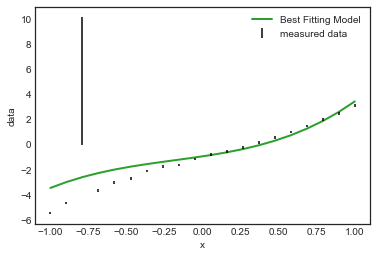

In [74]:
fig, ax = plt.subplots()
ax.errorbar(x, data, error, ls='', c='k', label='measured data')
ax.set(xlabel='x', ylabel='data')
best_fitting_w = np.linalg.solve(A.T.dot(A), A.T.dot(data))
# Best fitting weights:
plt.plot(x, A.dot(best_fitting_w), color='C2', label='Best Fitting Model', lw=2, zorder=-1)
plt.legend()

In the above example, we have a dataset with lots of well estimated datapoints (small errors) and one large outlier with a huge uncertainty. That one outlier (which we know to have a larger uncertainty) is pulling our solution to one side, because all the points have equal weights.

Instead of weighting all the points equally, we can instead have the weight of each point be given by our uncertainty in that measurement. We're going to weight each point by the inverse variance. We assume here that the "errors" reported with our data are the standard deviation, so the inverse variance for the $i$th point is $\frac{1}{\sigma_i^2}$. Weighting our cost function from the OLS derivation above, we can find a new cost function:

$J(\boldsymbol \theta) = \frac{1}{2n}\sum_{i=1}^m \frac{1}{\sigma_i^2} (y_i$ - $h_\theta(x_i))^2$


# Adding more robust noise to the model: Generalized Least Squares regression 

We've already understood how to add something like measurement errors to our model, but this isn't the end of adding noise. Let's learn how to add the missing piece; covariance. But, to do that, we'll need to talk about what covariance is first.

## Covariance

Covariance is a measure of whether two variables "vary" together. Variables are "covariant" if they both go up or both go down at the same time. 

In [13]:
a, b = np.random.normal(size=(2, 100))

[Text(0.5, 0, 'a'), Text(0, 0.5, 'b')]

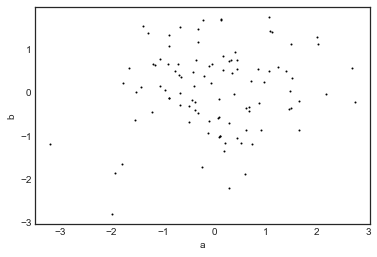

In [14]:
fig, ax = plt.subplots()
plt.scatter(a, b, c='k', s=1)
ax.set(xlabel='a', ylabel='b')

Covariance between two vectors $\mathbf x$ and $\mathbf y$ is given as

$\frac{1}{n}\sum^n_{i=0}(x_i  - \mathbf{\hat{x}})(y_i  - \mathbf{\hat{y}})$

where the hat symbol denotes the mean of the vector. If we look at the covariance for a and be we find a number very close to 0

In [15]:
np.sum((a - np.mean(a)) * (b - np.mean(b)))/len(a)

0.12470598245769468

In other words, they aren't covariant. Let's make a vector that is covariant

In [16]:
c = b + a * 1 + np.random.normal(size=(100))

[Text(0.5, 0, 'a'), Text(0, 0.5, 'c')]

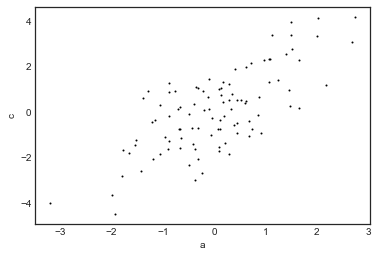

In [17]:
fig, ax = plt.subplots()
plt.scatter(a, c, c='k', s=1)
ax.set(xlabel='a', ylabel='c')

This time the covariance is a positive value much greater than 1, these are covariant vectors

In [18]:
np.sum((a - np.mean(a)) * (c - np.mean(c)))/len(a)

1.3641776341898577

Note that the "variance" of a vector is the covariance of the vector with itself!

### Covariance Matrix

In our case, we don't have just two vectors, we have a large number of vectors in our design matrix. If we want to know the covariance of each of our column vector regressors with each other, we can create a covariance matrix. 

In [19]:
X = np.vstack([a, b, c]).T

In [20]:
cov = (X - X.mean(axis=0)).T.dot((X - X.mean(axis=0)))/X.shape[0]

This will take the form

$\begin{bmatrix}
cov(a, a) &cov(a, b) &cov(a, c) \\
cov(b, a) &cov(b, b) &cov(b, c) \\
cov(c, a) &cov(c, b) &cov(c, c) \\
\end{bmatrix}$

or another way

$\begin{bmatrix}
var(a) &cov(a, b) &cov(a, c) \\
cov(b, a) &var(b) &cov(b, c) \\
cov(c, a) &cov(c, b) &var(c) \\
\end{bmatrix}$

In [21]:
cov

array([[1.14536886, 0.12470598, 1.36417763],
       [0.12470598, 0.87748305, 0.85642741],
       [1.36417763, 0.85642741, 3.06754659]])

You can see the variance of each vector in the diagonal, and the covariance of each vector pair in the off diagnoal terms.

### What do these matrices mean...?

Before we move on, let's just look at what different versions of this matrix would mean:

A covariance matrix like this
$\begin{bmatrix}
1 &0 &0 \\
0 &1 &0 \\
0 &0 &1 \\
\end{bmatrix}$

means that the input vectors **are uncorrelated**, because the off diagonal terms are 0. The **variance** of the vectors are the same, because the diagonal values are all the same.

A covariance matrix like this
$\begin{bmatrix}
3 &0 &0 \\
0 &1 &0 \\
0 &0 &2 \\
\end{bmatrix}$

means that the input vectors are uncorrelated and each vector has **different variance** because the diagonal terms are different. 

A covariance matrix like this
$\begin{bmatrix}
1 &0.2 &0.3 \\
0.2 &1 &0.4 \\
0.3 &0.4 &1 \\
\end{bmatrix}$

means that the vectors **are correlated**, and they have the same variance. 

### Covariance with weights

Frequently we have data with different weights. If we want to include errors in our covariance estimate, we can do so by weighting the covariance using those errors:

$cov(\mathbf x, \mathbf y) = \frac{1}{n}\sum^n_{i=0}\frac{(x_i  - \mathbf{\hat{x}})(y_i  - \mathbf{\hat{y}})}{\sigma_{x_i}\sigma_{y_i}}$

where $\sigma_{x_i}$ indicates the error on the $i$th element in the vector $\mathbf x$.

Let's make our data again, and this time, let's add a few outliers with larger errors

In [22]:
a, b = np.random.normal(0, 0.01, size=(2, 100))
c = b + a * 0.5 + np.random.normal(0, 0.1, size=(100))
bad_idx = np.random.choice(np.arange(100), 5)
a[bad_idx] += np.random.normal(0, 0.2, size=5)
b[bad_idx] += np.random.normal(0, 0.2, size=5)
c[bad_idx] += np.random.normal(0, 0.2, size=5)
err = np.ones(100) * 0.01
err[bad_idx] = (0.2**2 + 0.01**2)**0.5

Now I've made similar variables as before, but this time I've added five points that have more noise in them.

<ErrorbarContainer object of 3 artists>

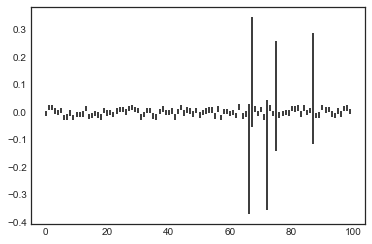

In [23]:
plt.errorbar(np.arange(100), a, err, ls='', c='k')

In [24]:
X = np.vstack([a, b, c]).T

If we assume the vectors all have equal errors we get the following covariance matrix

In [25]:
cov = ((X - X.mean(axis=0))/0.01**2).T.dot(((X - X.mean(axis=0))/0.01**2))/X.shape[0]

In [26]:
cov

array([[  95783.88229264,   81337.25022426,  -70798.84665131],
       [  81337.25022426,  235643.85831875,    8605.45498374],
       [ -70798.84665131,    8605.45498374, 1455636.98094312]])

This is incorrect, the values are very large, and the data has huge variance. 


If we assume the vectors have their correct errors we get

In [29]:
cov = (X - X.mean(axis=0)/err[:, None]**2).T.dot((X - X.mean(axis=0)/err[:, None]**2))/X.shape[0]

In [30]:
cov

array([[282.64852642, 295.53200061, 441.72290515],
       [295.53200061, 309.00441942, 461.85829911],
       [441.72290515, 461.85829911, 690.34329881]])

This is much better behaved and reflects the covariance of the data much more accurately.